In [6]:
# import library
import pandas as pd
import numpy as np

# files
import os
from shutil import copyfile
from google.colab import files

# visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px

# times
import time
from tqdm import tqdm 
from datetime import datetime

# classification library
import tensorflow as tf 
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

print("Setup Complete!")

Setup Complete!


In [7]:
# melakukan download file dalam bentuk zip
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip


--2020-11-01 05:34:34--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.48MB/s    in 40s     

2020-11-01 05:35:15 (7.79 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [8]:
# melakukan ekstraksi dari file zip

import zipfile
zip_local = '/tmp/rockpaperscissors.zip'
ref_zip = zipfile.ZipFile(zip_local,'r')
ref_zip.extractall('/tmp')
ref_zip.close()

In [9]:
#cek isi dari folder
os.listdir('/tmp/rockpaperscissors')

['paper', 'rock', 'README_rpc-cv-images.txt', 'scissors', 'rps-cv-images']

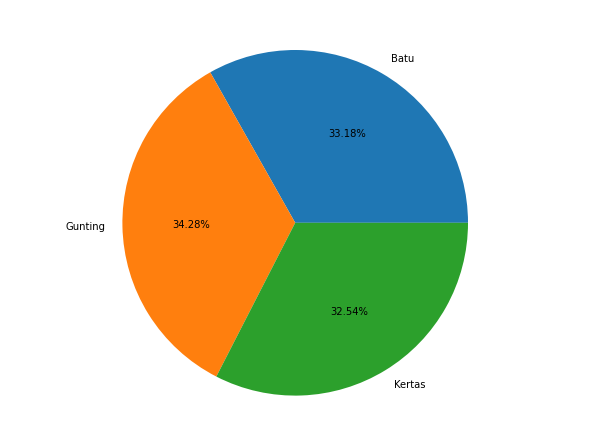

Banyaknya dataset Batu: 726
Banyaknya dataset Gunting: 750
Banyaknya dataset Kertas: 712


In [10]:
# visualisasi banyaknya dataset gambar, gunting, kertas
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6)) 
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

label = ['Batu', 'Gunting', 'Kertas']
Nilai = [len(os.listdir('/tmp/rockpaperscissors/rock')), 
         len(os.listdir('/tmp/rockpaperscissors/scissors')), 
         len(os.listdir('/tmp/rockpaperscissors/paper'))] 

ax.pie(Nilai,labels=label,autopct='%1.2f%%')
plt.show()

print('Banyaknya dataset Batu:', len(os.listdir('/tmp/rockpaperscissors/rock')))
print('Banyaknya dataset Gunting:', len(os.listdir('/tmp/rockpaperscissors/scissors')))
print('Banyaknya dataset Kertas:', len(os.listdir('/tmp/rockpaperscissors/paper')))

In [11]:
# define directory
image_dir = '/tmp/rockpaperscissors/rps-cv-images'

In [12]:
# create data generator

train_datagen = ImageDataGenerator( rescale = 1.0/255,
                                    rotation_range=50,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.15,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip = True,
                                    validation_split=0.4)

test_datagen = ImageDataGenerator(rescale = 1.0/255,
                                  rotation_range=50,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.15,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip = True,
                                  validation_split=0.4)

In [13]:
# Augmentasi Dataset(Preparing iterators for both train-test datasets)

image_data_train = train_datagen.flow_from_directory(image_dir,
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     target_size=(60, 40),
                                                     subset='training')

image_data_test = test_datagen.flow_from_directory(image_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(60, 40),
                                                    subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [14]:
# Menentukan Akurasi tiap model

def summarize_diagnostics(model):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss'] 

    epochs = range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize=(15,6), dpi=100)
    ax[0].plot(epochs, acc, 'r', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'r', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()

    plt.show()

# Model

In [15]:
# Tuning Parameter

model = Sequential()
# block 1
model.add(Conv2D(16, (5,5), input_shape=(60, 40, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
# block 2
model.add(Conv2D(32, (4,4), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(2,2))
# block 3
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'Same'))
model.add(MaxPooling2D(2, 2))
# block 4
model.add(Conv2D(128, (2, 2), activation = 'selu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

# print summary model
model.summary()

# compile model 
model.compile(loss='categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(amsgrad=True),  
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 36, 16)        1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 36, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 36, 32)        8224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 9, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 8, 128)        3

In [16]:
# Create Callbacks

checkpoint = ModelCheckpoint(filepath='model.{epoch:02d}-{accuracy:.2f}.h5',
                              monitor='accuracy',
                              verbose=2,
                              save_best_only=True,
                              mode='max',
                              save_weights_only=False)

adaptive_learning = ReduceLROnPlateau(patience=2,
                                      verbose=2,
                                      factor=0.5,
                                      min_lr=0.000003)

early_stop = EarlyStopping(monitor='accuracy', 
                           patience=10, 
                           verbose=2, 
                           mode='max')

tensorboard = TensorBoard(log_dir = './logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

In [17]:
# fit model ke data train kemudian evaluasi ke data testing
awal = datetime.now()

model_CNN = model.fit(image_data_train,
                      epochs = 15,
                      validation_data = image_data_test,
                      callbacks=[checkpoint, adaptive_learning, early_stop, tensorboard],
                      verbose = True)

akhir =  datetime.now()
print('Waktu yang diperlukan untuk seluruh replikasi:', 
      str(akhir-awal)[2:4], 'menit', 
      str(akhir-awal)[5:7], 'detik')

Epoch 1/15
 1/42 [..............................] - ETA: 0s - loss: 1.0670 - accuracy: 0.4062WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
42/42 [==============================] - ETA: 0s - loss: 0.7686 - accuracy: 0.6728
Epoch 00001: accuracy improved from -inf to 0.67275, saving model to model.01-0.67.h5
42/42 [==============================] - 18s 418ms/step - loss: 0.7686 - accuracy: 0.6728 - val_loss: 1.1537 - val_accuracy: 0.3318
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8455
Epoch 00002: accuracy improved from 0.67275 to 0.84551, saving model to model.02-0.85.h5
42/42 [==============================] - 17s 411ms/step - loss: 0.3933 - accuracy: 0.8455 - val_loss: 1.1621 - val_accuracy: 0.3330
Epoch 3/15
42

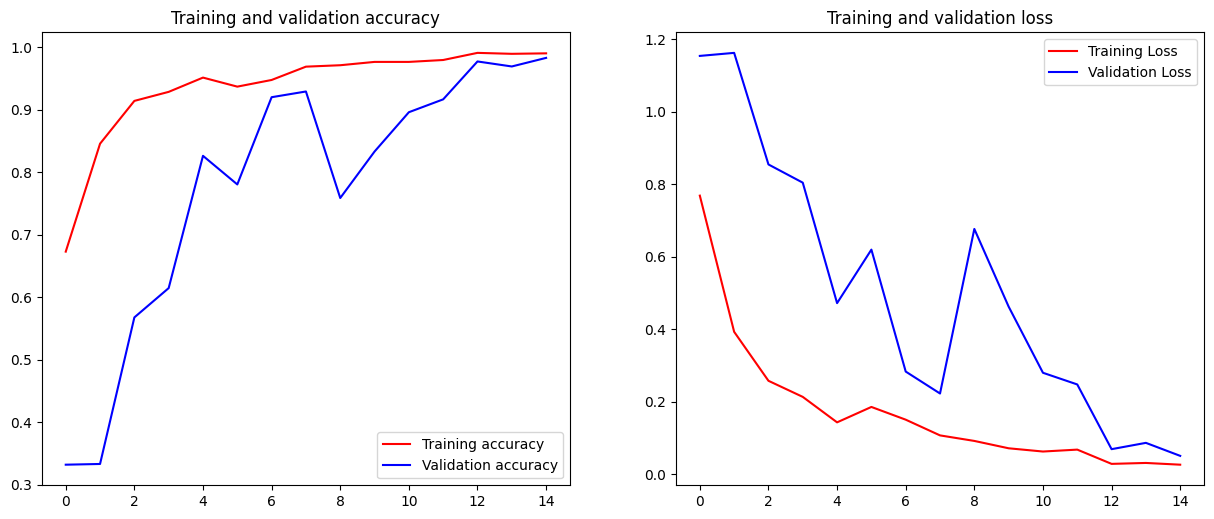

In [18]:
summarize_diagnostics(model_CNN)

In [19]:
model_CNN.history['accuracy'][-1]
print('Training Accuracy on data test is %.3f' % (model_CNN.history['accuracy'][-1] * 100.0))
print('Training Validation Accuracy on data test is %.3f' % (model_CNN.history['val_accuracy'][-1] * 100.0))
print('===========================================')
print('Training Loss Accuracy on data test is %.6f' % (model_CNN.history['loss'][-1]))
print('Training Loss Validation on data test is %.6f' % (model_CNN.history['val_loss'][-1]))

Training Accuracy on data test is 99.011
Training Validation Accuracy on data test is 98.284
Training Loss Accuracy on data test is 0.026989
Training Loss Validation on data test is 0.051301


Saving 3bkC6JAPog7xX9WO.png to 3bkC6JAPog7xX9WO (5).png
3bkC6JAPog7xX9WO.png
SCISSORS


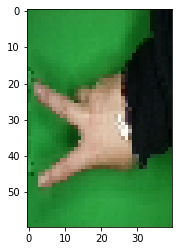

In [22]:
%matplotlib inline

gambar_upload = files.upload()

for nama_file in gambar_upload.keys():
    Image = image.load_img(nama_file, target_size =(60,40))

    imgplot = plt.imshow(Image)
    x = image.img_to_array(Image)
    x = np.expand_dims(x, axis=0) 

    images = np.vstack([x])/255
    classes = model.predict(images, batch_size=32)
    print(nama_file)

    if round(classes[0,0])==1:
        print('PAPER')
    elif round(classes[0,1])==1:
        print('ROCK')
    else:
        print('SCISSORS')